 # Wavalet Packet Transformation

In [66]:
import pywt
import torch
import torch.nn.functional as F

%matplotlib inline

## Ilustração do efeito 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8a0eb26128>)

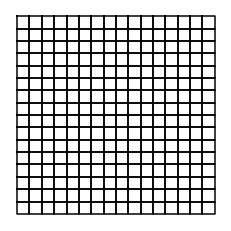

In [10]:
from itertools import product
from pywt._doc_utils import draw_2d_wp_basis

max_lev = 4       # how many levels of decomposition to draw
label_levels = 2  # how many levels to explicitly label on the plots
shape = (512, 512)

fig, axes = plt.subplots(1, 1)

# get all keys corresponding to a full wavelet packet decomposition
wp_keys = list(product(['a', 'd', 'h', 'v'], repeat=max_lev))
draw_2d_wp_basis(shape, wp_keys, ax=axes)
# axes[2].set_title('wavelet packet\n(full: {} level)'.format(max_lev))

## Implementação com torch.nn.Conv2d

Define para a familia de funções desejada o tensor com os filtros LL, LH, HL e HH

In [267]:
# A familia de wavelet
w=pywt.Wavelet('db1')

# do fliplr e transforma em tensor
dec_hi = torch.Tensor(w.dec_hi[::-1]) 
dec_lo = torch.Tensor(w.dec_lo[::-1])

# calcula produtos externos entre todos formando: LL, LH, HL e HH; e empilha tudo em um tensor
filters = torch.stack([dec_lo.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_lo.unsqueeze(0)*dec_hi.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_lo.unsqueeze(1),
                       dec_hi.unsqueeze(0)*dec_hi.unsqueeze(1)], dim=0)

# Adiciona 1 dim singleton p/ dar certo na multiplicaçao depois pq deve ser 4d: (out_ch, in_ch, kH, k, W)
filters[:, None].shape

torch.Size([4, 1, 2, 2])

O método em si que implementa WPT com conv2d

In [268]:
def wt(x, levels=1):
    b, c, h, w = x.shape
    p1, p2 = (levels+1) % 2, levels % 2 # padding ora em cima e a esquerda, ora embaixo e a direita
    x = x.view(b*c, 1, h, w) # DWT deve ser aplicada separadamente em cada canal RGB
    xpad = F.pad(x, (p1,p2,p1,p2), mode='reflect')
    x = F.conv2d(xpad, filters[:, None], stride=2)  # já faz o downsampling de 2 na altura e largura 
    if levels>1:
        x = wt(x, levels-1) # se for decomposição em vários níveis chama a func recursivamente  

    # organiza tudo novamente com os mesmo nb inicial de imgs no batch e os coeffs na dim dos canais    
    x = x.view(b,-1, *x.shape[2:])
    return x

## Exemplo

In [91]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

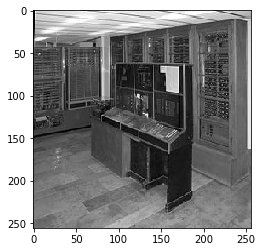

In [103]:
imgraw = Image.open('museum.jpg').resize((256,256))
img = np.array(imgraw).mean(2)/255
img = torch.from_numpy(img).float()
plt.imshow(img, cmap=plt.cm.gray)

Converte img original para tensor e põe em escala de cinza

In [266]:
img_tensor = transforms.ToTensor()(imgraw)
img_batch = img_tensor.expand(1,-1,-1,-1).mean(1, keepdim=True)
img_batch.size()

torch.Size([1, 1, 256, 256])

In [269]:
out = wt(img_batch, 1)
out.shape

torch.Size([1, 4, 128, 128])

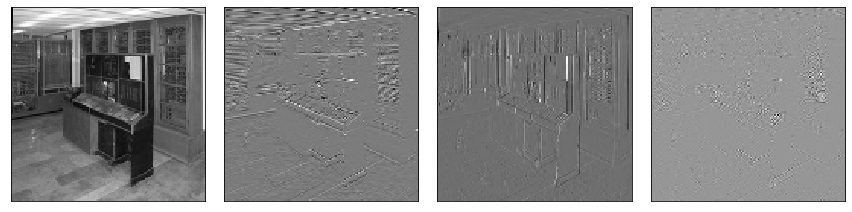

In [323]:
k = out.numpy().squeeze()

fig, axs = plt.subplots(1, 4, figsize=[12,3])
for idx, ax in enumerate(axs):
    ax.imshow(k[idx], interpolation="nearest", cmap=plt.cm.gray)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

## Comparação com o `pywavelets`

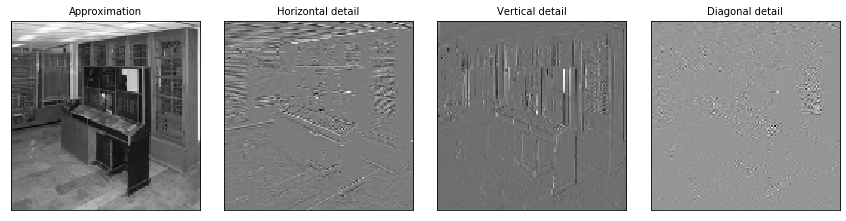

In [322]:
# Load image
original = img_tensor.mean(0).numpy()
# original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', 'Horizontal detail',
          'Vertical detail', 'Diagonal detail']

coeffs2 = pywt.dwt2(original, 'db1', mode='reflect')
LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

In [308]:
for i, a in enumerate([LL, LH, HL, HH]):
    print('{} : {}'.format(titles[i], np.allclose(a, k[i])))

Approximation : True
Horizontal detail : False
Vertical detail : False
Diagonal detail : False


Comparando visualmente nota-se que os coeficientes de decomposição estão um pouco diferentes.  
A boa notícia é que a operação feita com conv2d está certa (ao menos não está bagunçando as dimensões)